In [1]:
if 'google.colab' in str(get_ipython()):
    print("Running on Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    #===== FIX THIS PATH =====
    %cd "/content/drive/My Drive/[PATH TO PROJECT FOLDER ON GDRIVE]"
    #===== FIX THIS PATH =====

    %pip install imblearn # Used for resampling dataset (not pre-installed on Colab)
else:
    print("Not running on Google Colab")

Not running on Google Colab


# Utility code

In [2]:
import pandas as pd
import seaborn as sns
import os.path
import pickle
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Image
import sklearn
import matplotlib.pyplot as plt
import numpy as np

print(f'The scikit-learn version is {sklearn.__version__}')

The scikit-learn version is 1.2.2


In [3]:
RANDOM_STATE = 69420

sns.set_theme(font_scale=.7)
pd.set_option("display.precision", 4)

CACHE_DIR = "cache"

# Create cache directory if not already present
if not os.path.isdir(CACHE_DIR):
    os.makedirs(CACHE_DIR)

def load_pickle(p):
    with open(p, "rb") as f:
        return pickle.load(f)

def dump_pickle(obj, p):
    with open(p, "wb") as f:
        pickle.dump(obj, f)

def grid_search(params, scores, base_model, Xtr, ytr, Xte, yte,
                n_splits=3, n_jobs=None, random_state=RANDOM_STATE,
                pickle_file="", overwrite_pickle=False, verbose=1):
    """
    Perform a grid search on a given model using the given parameters and scores

    Parameters
    ----------
    params : dict
        A dictionary containing the parameters to be tested in the grid search
    scores : list or string
        A list of strings containing the scores to be used in the grid search
    base_model : sklearn estimator
        The estimator object to optimize
    Xtr : np.array
        The training data
    ytr : np.array
        The training labels
    Xte : np.array
        The testing data
    yte : np.array
        The testing labels
    n_splits : int (default: 3)
        The number of splits to be used in the cross validation
    n_jobs : int or None (default: None)
        Number of threads to use. None means 1 and -1 means using all available
    random_state : int
        The random seed to be used in the cross validation
    pickle_file : str
        The path to the pickle file to be used to cache the grid search results
    overwrite_pickle : bool
        Whether to overwrite the pickle file if it already exists

    Returns
    -------
    dict
        A dictionary containing the results of the grid search
    """

    # If no pickle file is given, use the model's name as the pickle file
    if pickle_file.strip() == "":
        pickle_file = base_model.__class__.__name__ + "__gridsearch.pickle"
    
    pickle_file = os.path.join(CACHE_DIR, pickle_file)

    # If the pickle file already exists and we don't want to overwrite it, load the results from it and return
    if os.path.isfile(pickle_file) and not overwrite_pickle:
        print(f"Grid search already cached in {pickle_file} - loading...")
        return load_pickle(pickle_file)

    # Create a stratified k-fold object
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    results = {}

    # If passed a single score as a string, wrap it in a list
    if type(scores) == str:
        scores = [scores]

    # GridSearchCV expects a list of dictionaries,
    # so if passed a single dictionary, wrap it in a list
    if not type(params) is list:
        params = [params]

    for score in scores:
        print(f"Tuning hyperparameters for: {score}...")

        clf = GridSearchCV(estimator=base_model,#sklearn.base.clone(base_model),
                        param_grid=params,
                        scoring=score,
                        return_train_score=False,
                        n_jobs=n_jobs,
                        cv=skf, verbose=verbose)

        clf.fit(Xtr, ytr)

        # Retrieve the best model from the grid search
        best_model = clf.best_estimator_
        classes = best_model.classes_

        y_pred = best_model.predict(Xte)

        # Generate classification report and confusion matrix
        report = classification_report(yte,y_pred, zero_division=0)
        cm = confusion_matrix(yte, y_pred, labels=classes, normalize="true")

        results[score] = {
            "model": best_model,
            "report": report,
            "matrix": cm
        }

        print("done")

    # Cache the results in a pickle file
    with open(pickle_file, "wb") as f:
        print(f"Caching grid search result in {pickle_file}...")
        pickle.dump(results, f)

    return results

def fit_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model and predict the test data

    Parameters
    ----------
    model : sklearn BaseEstimator
        The model to be used
    X_train : np.array
        The training data
    y_train : np.array
        The training labels
    X_test : np.array
        The testing data
    y_test : np.array
        The testing labels

    Returns
    -------
    y_pred, rep, cm
        predicted labels, the classification report and the confusion matrix
    """

    print("Fitting model...", end="")
    model.fit(X_train, y_train)
    print("done")

    print("Testing...", end="")
    y_pred = model.predict(X_test)
    print("done")

    rep = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_, normalize="true")

    return y_pred, rep, cm

def print_model_results(model, report, conf_matrix, conf_matrix_title = ""):
    """

    Print the results of a model

    Parameters
    ----------
    model : sklearn BaseEstimator
        The model of which to print the parameters
    report : str
        The classification report
    conf_matrix : np.array
        The confusion matrix
    conf_matrix_title : str (default: "")
        The title of the confusion matrix plot. If empty, defaults to the class name of the model
    """

    print("Classification report:")
    print(report)

    print(f"Best parameters:")
    print(*[f"\t{n}: {v}" for n, v in model.get_params().items()], sep="\n")

    print()

    # If the model has feature importances, print them
    # (applies for tree-based models)
    if hasattr(model, "feature_importances_"):
        names = model.feature_names_in_
        print("Feature importances:")
        for name, imp in zip(names, model.feature_importances_):
            print(f"\t{name}: {imp:.3f}")

    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    disp.plot()
    disp.ax_.get_images()[0].set_clim(0, 1)

    if conf_matrix_title == "":
        conf_matrix_title = model.__class__.__name__
    
    disp.ax_.set_title(conf_matrix_title)
    disp.ax_.grid(False)

def print_gridsearch_results(results, cm_model_name=""):
    """
    Print information about the best model for each score in the grid search results

    Parameters
    ----------
    results : dict
        The results of calling grid_search
    features : list
        The features used in the model
    """

    for score, res in results.items():
        print("-" * 20)
        print(f"Score: {score}")

        if cm_model_name == "":
            cm_title = res['model'].__class__.__name__

        cm_title = f"{cm_model_name} - Tuned for {score}"

        print_model_results(res["model"], res["report"], res["matrix"], conf_matrix_title=cm_title)

def pairplot_or_image(data, img_path, target, overwrite=False, diag_kind="auto", height=1.5, legend=True):
    """
    Display a pairplot of the data. If the cached image already exists, display it instead

    Parameters
    ----------
    data : pd.DataFrame
        The data to plot
    img_path : str
        The path to save the image
    target : str
        The target variable
    overwrite : bool (default: False)
        Whether to overwrite the image if it already exists
    diag_kind : str (default: "auto")
        The kind of plot to use on the diagonal
    height : float (default: 1.5)
        The height of the plot
    legend : bool (default: True)
        Whether to display the legend
    """

    img_path = os.path.join(CACHE_DIR, img_path)

    if os.path.isfile(img_path) and not overwrite:
        display(Image(filename=img_path))
    else:
        pplot = sns.pairplot(data, hue=target, diag_kind=diag_kind, height=height)

        if not legend:
            pplot._legend.remove()

        pplot.figure.savefig(img_path)

# Forgot to store the classification report as a dictionary
# so we need to parse the report string
def report_str_to_dict(rep, n_classes=2):
    """
    Convert a classification report string to a dictionary

    Parameters
    ----------
    rep : str
        The classification report string
    n_classes : int (default: 2)
        The number of classes in the report 

    Returns
    -------
    dict
        A dictionary containing the classification report, formatted as follows:
        ```
        {
            "class1": {
                "precision": float,
                "recall": float,
                "f1-score": float,
                "support": float
            },
            "class2": {...},
            ...
            "classN": {...},
            "accuracy": float,
            "macro_avg": {
                "precision": float,
                "recall": float,
                "f1-score": float
            },
            "weighted_avg": {
                "precision": float,
                "recall": float,
                "f1-score": float
            },
            "support": float
        }
        ```
    """

    rep = rep.strip()
    lines = rep.split("\n")

    class_lines = [l.split() for l in rep.split("\n")[2:2+n_classes]]
    classes_dict = {l[0]: {k: float(v) for k, v in zip(["precision", "recall", "f1-score", "support"], l[1:])} for l in class_lines}

    global_lines = [l.replace(" avg", "_avg").split() for l in lines[-3:]]
    total_support = float(global_lines[0][-1])
    global_dict = {l[0]: l[1:-1] for l in global_lines}

    global_dict["accuracy"] = float(global_dict["accuracy"][0])

    averages = ["macro_avg", "weighted_avg"]

    for avg in averages:
        global_dict[avg] = {k: float(v) for k, v in zip(["precision", "recall", "f1-score"], global_dict[avg])}

    global_dict["support"] = total_support

    # merge the two dictionaries
    rep_dict = {**classes_dict, **global_dict}

    return rep_dict

def plot_old_to_new(old_dict, new_dict,
                    xlabel="", ylabel="", title="",
                    show_values=True, x_padding=.05, ax=None,
                    color_direction=True, x_range=None, yticks=True):
    """
    Plot a comparison between two dictionaries, assumed to have the same keys

    Parameters
    ----------
    old_dict : dict
        Dictionary with the old values
    new_dict : dict
        Dictionary with the new values
    xlabel : str (default: "")
        The x-axis label
    ylabel : str (default: "")
        The y-axis label
    title : str (default: "")
        The title of the plot
    show_values : bool (default: True)
        Whether to label each point with its value
    x_padding : float (default: .05)
        The padding to add to the x-axis limits
    ax : plt.Axes (default: None)
        The axes object to plot on. If None, a new figure is created
    color_direction : bool (default: True)
        Whether to color the arrows based on the direction of change
    x_range : tuple (default: None)
        The range of the x-axis. If None, the range is determined from the values
    yticks : bool (default: True)
        Whether to show the y-ticks labels
    """

    names = list(old_dict.keys())
    names.reverse()

    old_values = [old_dict[n] for n in names]
    new_values = [new_dict[n] for n in names]

    # Number of objects
    n = len(names)

    # Positions for the objects on the y-axis
    y_positions = np.arange(n)

    # The changes in value
    delta_values = np.array(new_values) - np.array(old_values)

    # Create the plot
    if ax is None:
        _, ax = plt.subplots()

    ax.title.set_text(title)

    went_up = [delta > 0 for delta in delta_values]

    # Determine the colors based on the direction of change
    colors = ["black" for _ in names] if not color_direction else ['green' if went_up[i] else 'red' for i, _ in enumerate(names)]

    # Plot the arrows with colors
    for i in range(n):
        ax.quiver(old_values[i], y_positions[i], delta_values[i], 0,
                  angles='xy', scale_units='xy', scale=1, color=colors[i],
                  width=.005, headwidth=3, headlength=3)

    if show_values:
        # Label the points
        for i, _ in enumerate(names):
            ax.text(old_values[i], y_positions[i], f'{old_values[i]}', ha='right' if went_up[i] else "left", va='center')
            ax.text(new_values[i], y_positions[i], f'{new_values[i]}', ha='left' if went_up[i] else "right", va='center')

    # Set the y-ticks to the object names
    ax.set_yticks(y_positions)
    if yticks:
        ax.set_yticklabels(names)
    else:
        ax.set_yticklabels([])

    # Set labels
    if xlabel != "":
        ax.set_xlabel(xlabel)
    if ylabel != "":
        ax.set_ylabel(ylabel)

    # Determine the x-axis limits

    if x_range is not None:
        min_value, max_value = x_range
    else:
        min_value = min(min(old_values), min(new_values))
        max_value = max(max(old_values), max(new_values))

    # Set the x-axis limits with padding
    ax.set_xlim(min_value - x_padding, max_value + x_padding)

    # Show grid
    ax.grid(True)

    if ax is None:
        # Display the plot
        plt.show()


# Data preparation

The dataset contains the following attributes:


| **ATTRIBUTE**       | **DATATYPE** | **DESCRIPTION**                                                         |
|---------------------|:------------:|-------------------------------------------------------------------------|
| id                  | Int          | Device identifier  |
| Product Id          | String       | Unique Id, combination of the Type attribute and a number identifier |
| Type                | String       | Type of product/device (possible values: "L","M","H") |
| Air Temperature     | Float        | Air temperature (Kelvin) |
| Process Temperature | Float        | Production process temperature (Kelvin) |
| Rotational Speed    | Int          | Speed in RPM |
| Torque              | Float        | Torque in Nm (Newton Meter) |
| Tool Wear           | Int          | Time unit needed to wear down the product/tool |
| TWF                 | Int          | Tool Wear Failure (binary) |
| HDF                 | Int          | Heat Dissipation Failure (binary) |
| PWF                 | Int          | Power Failure (binary) |
| OSF                 | Int          | Overstrain Failure (binary) |
| RNF                 | Int          | Random Failure (binary) |
| _Machine Failure_   | Int          | Failure binary feature (*class attribute*) |


More domain knowledge details can be found [here](https://www.kaggle.com/competitions/playground-series-s3e17/discussion/416765).

## Preprocessing

In [4]:
data = pd.read_csv("BCMF_data.csv")
data.set_index("id", inplace=True)

print(f"Total size: {len(data)}")

Total size: 136429


Here we see the main characteristic of this dataset, its *extreme imbalance*. This is dealt with in the following sections, first by oversampling the minority class, and by choosing the macro recall average as a metric for tuning.

In [5]:
target = "Machine failure"

data[target] = data[target].astype("category")

c0, c1 = data[target].value_counts()
ratio = c0 / c1

print(f"Class 0: {c0} ({c0 / len(data) * 100:.2f}%)")
print(f"Class 1: {c1} ({c1 / len(data) * 100:.2f}%)")
print(f"Ratio: {ratio:.2f}:1")

Class 0: 134281 (98.43%)
Class 1: 2148 (1.57%)
Ratio: 62.51:1


The "Product ID" attribute is irrelevant for this project

In [6]:
data.drop(columns=["Product ID"], inplace=True)

Converting the "type" attribute from categorical to numerical

In [7]:
data["Type"] = data["Type"].astype("category")
# We need to convert the type to an actual numerical value to perform
# resampling later
data["Type"] = data["Type"].cat.codes

This dataset was artificially generated [from another one](https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions/data), so there are (very) few inconsistencies. Namely, the TWF,HDF,PWF,OSF and RNF columns indicate the type of failure (see [here](https://www.kaggle.com/competitions/playground-series-s3e17/discussion/416765)) but we can find a small number of rows that have failure indicators set to a value different from the class attribute.

These inconsistent rows are removed since their whole data isn't considered reliable. We then also remove these failure indicators since they become redundant.

In [8]:
# Rows where the target is 0 and TWF, HDF, PWF, OSF, RNF are 1 are invalid
# Rows where the target is 1 and TWF, HDF, PWF, OSF, RNF are all 0 are invalid
data['tmp'] = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

invalid = data[(data[target] == 0) & (data["tmp"] != 0)].index
invalid = invalid.append(data[(data[target] == 1) & (data["tmp"] == 0)].index)

print(f"{len(invalid)} invalid rows")
# Remove rows
data.drop(invalid, inplace=True)

# Remove TWF, HDF, PWF, OSF, RNF columns
data.drop(columns=["tmp", "TWF", "HDF", "PWF", "OSF", "RNF"], inplace=True)

822 invalid rows


In [9]:
# The describe() method doesn't apply to categorical columns (like Type)
data.drop(columns=["Type"]).describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,135607.0000,135607.0000,135607.0000,135607.0000,135607.0000
mean,299.8605,309.9402,1520.4675,40.3192,104.3506
std,1.8613,1.3851,137.8523,8.4648,63.9209
min,295.3000,305.8000,1181.0000,3.8000,0.0000
25%,298.3000,308.7000,1432.0000,34.6000,48.0000
50%,300.0000,310.0000,1493.0000,40.4000,106.0000
75%,301.2000,310.9000,1580.0000,46.0000,159.0000
max,304.4000,313.8000,2886.0000,76.6000,253.0000


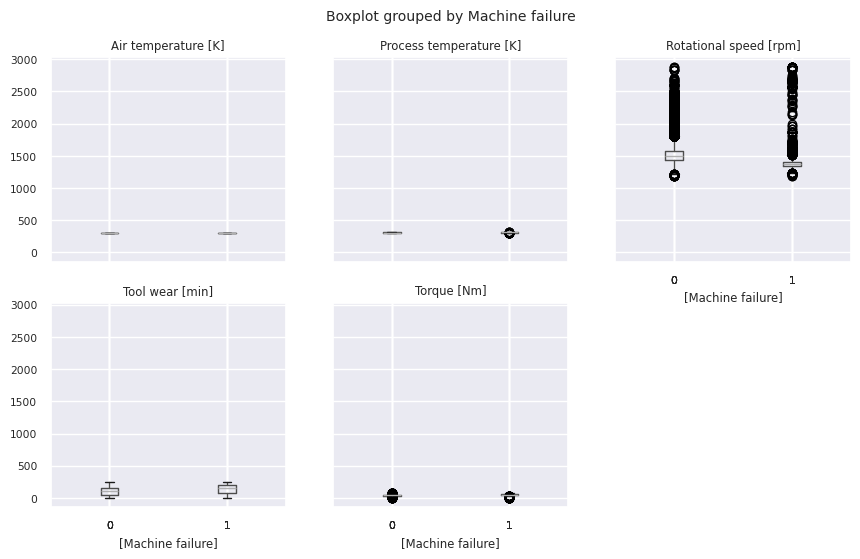

In [10]:
data.drop(columns=["Type"]).boxplot(figsize=(10, 6), by=target, layout=(2, 3));

This boxplot (and the previous description) shows that the attributes have widely different scales, so we need to normalize them

In [11]:
for col in [c for c in data.columns if not c in [target, "Type"]]:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

The following plots show the final distributions of the attributes. Due to the high imbalance, the pairplot had to be split between the classes so that the plots for the "Failed" class could be seen.

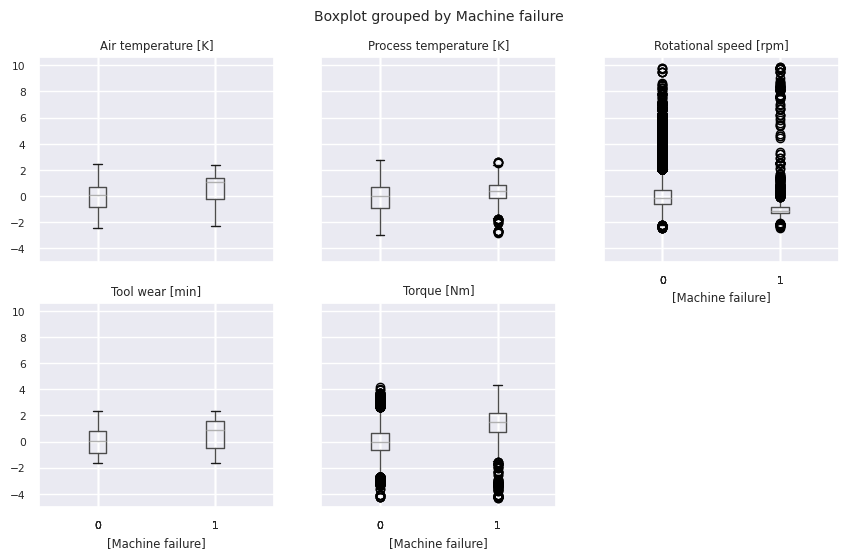

In [12]:
data.drop(columns=["Type"]).boxplot(figsize=(10, 6), by=target, layout=(2, 3));

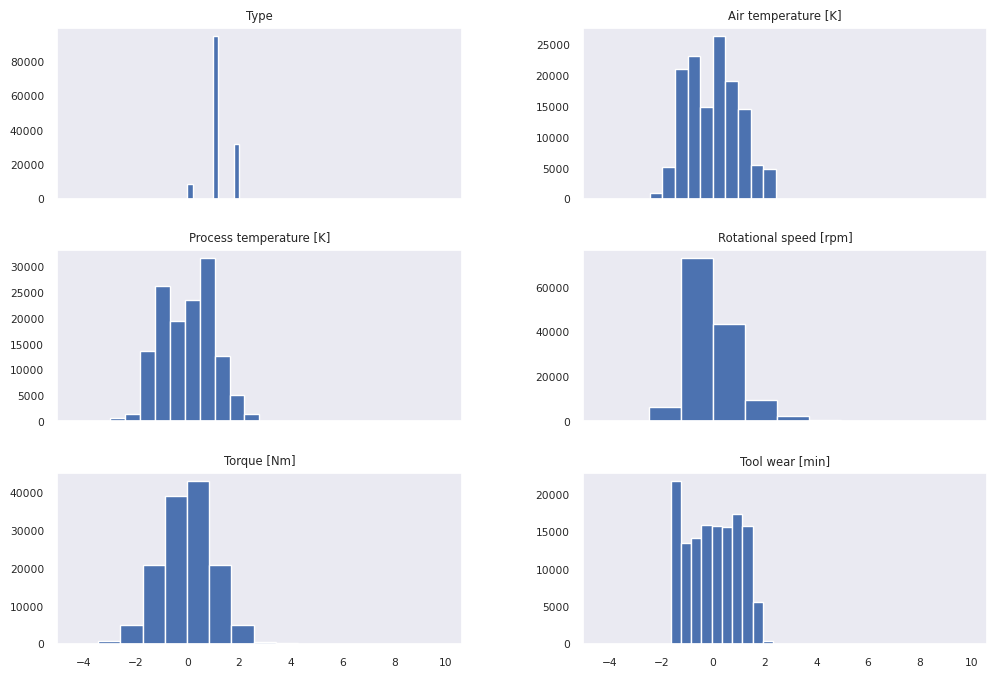

In [13]:
data.hist(grid=False, sharex=True, figsize=(12, 8));

In [14]:
# Due to the high imbalance, the minority class ends up being barely noticable in this plot,
# hence the separation
#pairplot_or_image(data, "full_pairplot.png", target)

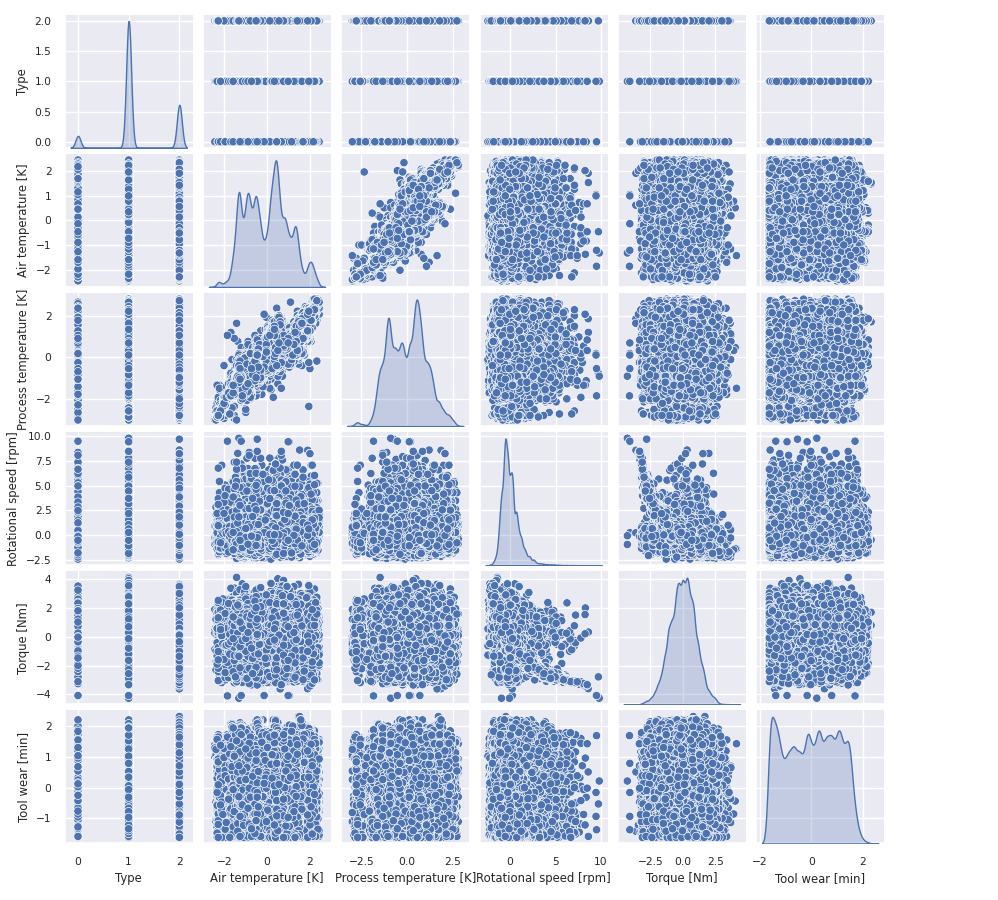

In [15]:
pairplot_or_image(data[data[target] == 0], "not_failed.png", target, overwrite=False, legend=False)

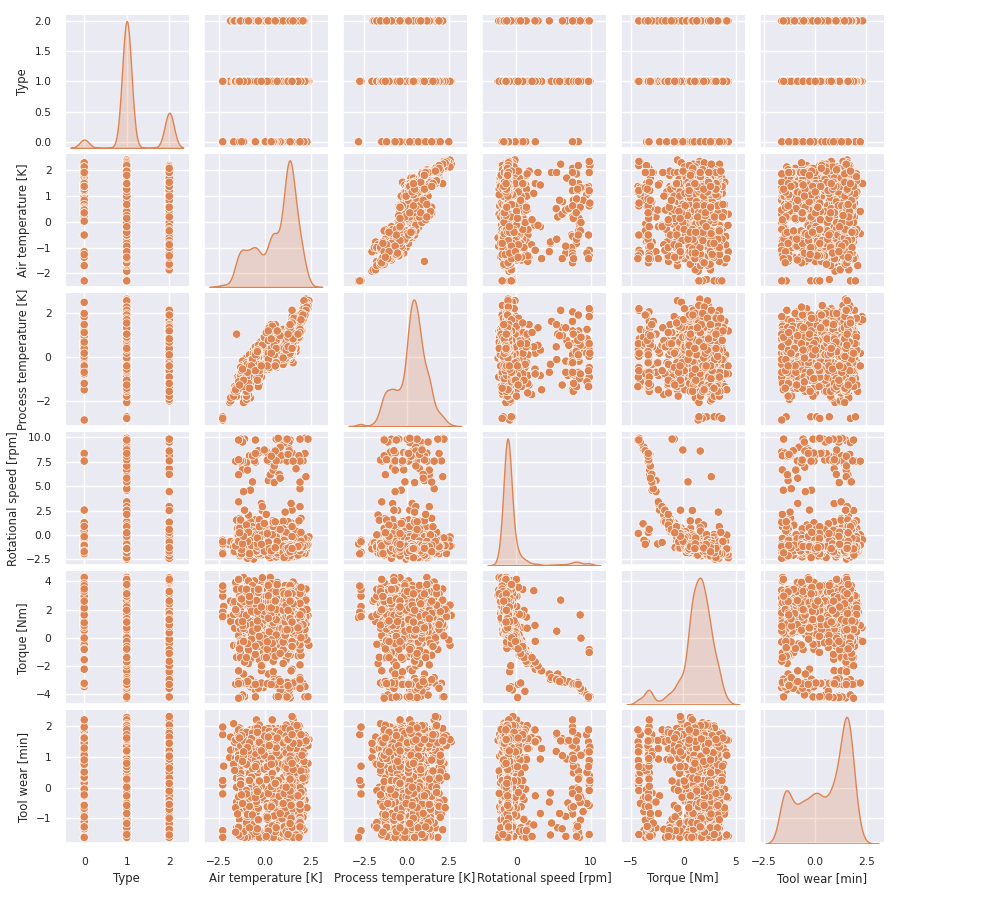

In [16]:
pairplot_or_image(data[data[target] == 1], "failed.png", target, overwrite=False, legend=False)

## Resampling & train/test split

In [17]:
# Basic paramters
test_size = 0.2

X = data.drop(columns=[target], axis=1)
y = data[target]

Resampling allows us to change the minority-majority class ratio. This can be done by either:
- *over*-sampling the minority, i.e. duplicating minority datapoints
- *under*-sampling the majority, i.e. removing majority datapoints

The first option could lead to overfitting but doesn't remove any data. The second option, however, to achieve the desired ratio would have to remove a lot of data, *for this particular dataset*. We therefore choose the over-sampling method.

With the imblearn library, this is done using the [SMOTE](https://arxiv.org/abs/1106.1813) method.

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

Xtr_orig, Xte, ytr_orig, yte = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

print(f"Test set size: {len(Xte)}")

# Resample to get a different ratio between minority and majority
resampler = SMOTE(random_state=RANDOM_STATE, sampling_strategy=(1. / 10.))

Xtr, ytr = Xtr_orig, ytr_orig

if resampler is not None:
    Xtr, ytr = resampler.fit_resample(Xtr_orig, ytr_orig)

    print(f"Initial train size: {len(Xtr_orig)}")

    print(f"Resampled train size: {len(Xtr)}")
else:
    print(f"Train size: {len(Xtr)}")

Test set size: 27122
Initial train size: 108485
Resampled train size: 117901


# Models

We test the following estimators, from the scikit-learn library:
- [Decision Tree](#decision-tree)
- [Random Forest](#random-forest)
- [AdaBoost](#adaboost)
- [$k$-Nearest Neighbors](#k-nearest-neighbor)
- [Gaussian Naive Bayes](#gaussian-naive-bayes)
- [Perceptron](#perceptron)
- [Support Vector Machine](#support-vector-machine)
- [SGD](#gradient-descent)

For each model, we compute a baseline first and then we tune the hyperparameters using a grid search. The estimators are presented in the order in which they've been tested and (almost) all discussion of the results has been left for the "Conclusion" section at the end.

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

This model will be tested on both the original and resampled datasets.

### Baseline

#### Original dataset

In [20]:
base_dt_orig = DecisionTreeClassifier(random_state=RANDOM_STATE)

y_pred, rep, cm = fit_and_predict(base_dt_orig, Xtr_orig, ytr_orig, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.37      0.39      0.38       339

    accuracy                           0.98     27122
   macro avg       0.68      0.69      0.69     27122
weighted avg       0.98      0.98      0.98     27122

Best parameters:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: 69420
	splitter: best

Feature importances:
	Type: 0.031
	Air temperature [K]: 0.179
	Process temperature [K]: 0.146
	Rotational speed [rpm]: 0.181
	Torque [Nm]: 0.288
	Tool wear [min]: 0.175


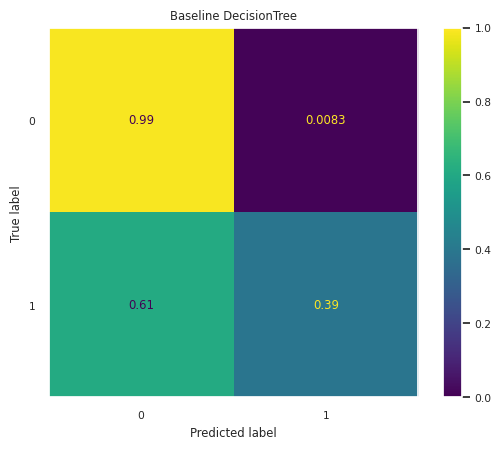

In [21]:
print_model_results(base_dt_orig, rep, cm, "Baseline DecisionTree")

In [22]:
print(f"Tree depth: {base_dt_orig.get_depth()}")

Tree depth: 30


In [23]:
base_dt_orig.tree_.node_count

3139

#### Oversampled dataset

In [24]:
base_dt_os = DecisionTreeClassifier(random_state=RANDOM_STATE)

y_pred, rep, cm = fit_and_predict(base_dt_os, Xtr, ytr, Xte, yte)

Fitting model...

done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.27      0.44      0.34       339

    accuracy                           0.98     27122
   macro avg       0.63      0.71      0.66     27122
weighted avg       0.98      0.98      0.98     27122

Best parameters:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: 69420
	splitter: best

Feature importances:
	Type: 0.013
	Air temperature [K]: 0.219
	Process temperature [K]: 0.109
	Rotational speed [rpm]: 0.292
	Torque [Nm]: 0.223
	Tool wear [min]: 0.144


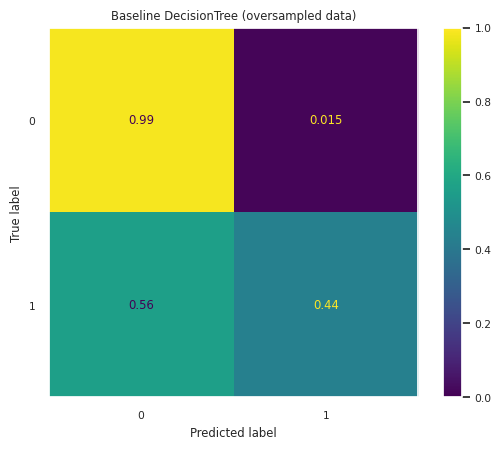

In [25]:
print_model_results(base_dt_os, rep, cm, "Baseline DecisionTree (oversampled data)")

In [26]:
print(f"Tree depth: {base_dt_os.get_depth()}")

Tree depth: 35


In [27]:
base_dt_os.tree_.node_count

5865

As will be the case for all following models, the baseline(s) show an "alleged" accuracy around 98%, actually due to the high imbalance. The following gridsearch will show which alternative metric was chosen to optimize each estimator.

Finally, though the effect isn't too pronounced, the model performs better on the resampled dataset. This is expected, as the model is able to learn more from the minority class, and such data will be used for the following models.

In [28]:
base_rep_dt = rep

### Grid search

In [29]:
max_depth = base_dt_os.get_depth()+1

results_dt = grid_search({'max_depth': [*range(4,max_depth)],
                       'criterion' : ['entropy', 'gini'],
                       "class_weight": [None, "balanced"]},
                      # Searching over all metrics will take around 30 minutes using Colab
                      ["precision_macro", "recall_macro", "f1_macro", "accuracy"],
                      base_dt_os, Xtr, ytr, Xte, yte)

Grid search already cached in cache/DecisionTreeClassifier__gridsearch.pickle - loading...


--------------------
Score: precision_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.34      0.49      0.40       339

    accuracy                           0.98     27122
   macro avg       0.67      0.74      0.70     27122
weighted avg       0.99      0.98      0.98     27122

Best parameters:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: 14
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: 69420
	splitter: best

Feature importances:
	Type: 0.012
	Air temperature [K]: 0.218
	Process temperature [K]: 0.091
	Rotational speed [rpm]: 0.308
	Torque [Nm]: 0.235
	Tool wear [min]: 0.137
--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     267

--------------------
Score: accuracy
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.26      0.42      0.32       339

    accuracy                           0.98     27122
   macro avg       0.63      0.70      0.66     27122
weighted avg       0.98      0.98      0.98     27122

Best parameters:
	ccp_alpha: 0.0
	class_weight: balanced
	criterion: entropy
	max_depth: 32
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: 69420
	splitter: best

Feature importances:
	Type: 0.013
	Air temperature [K]: 0.116
	Process temperature [K]: 0.078
	Rotational speed [rpm]: 0.365
	Torque [Nm]: 0.243
	Tool wear [min]: 0.185


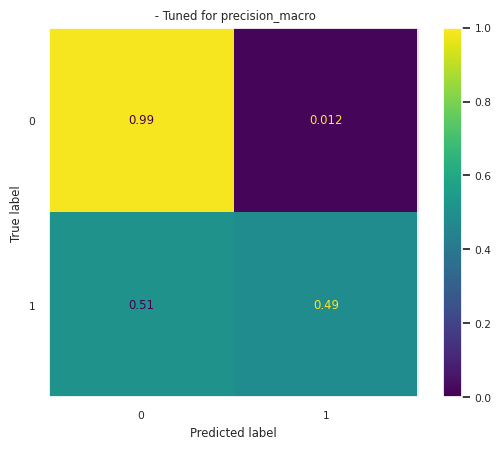

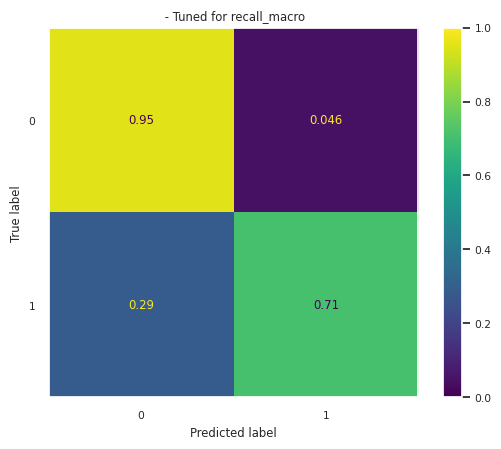

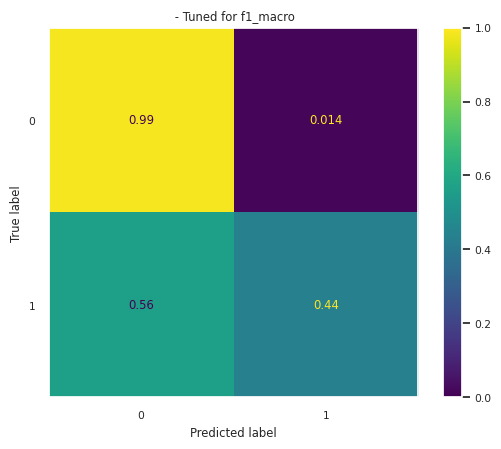

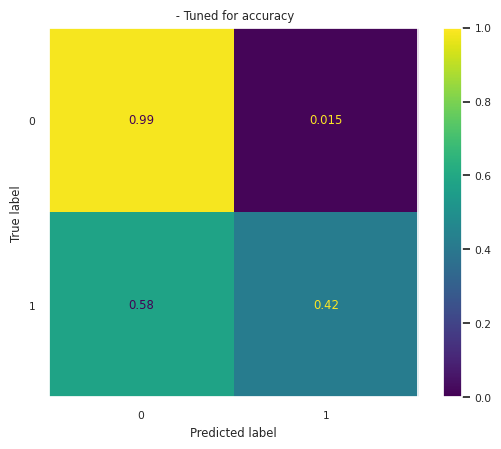

In [30]:
print_gridsearch_results(results_dt)

We clearly see that targeting the `recall_macro` metric produces a far better estimator compared to those obtained for the other metrics, whose performance remains close to the baseline. This is expected, since it requires the model to classify correctly a higher percentage of datapoints *for both classes*. Due to this outstanding result, for all following models this will be the only metric used in the grid searches.

The optimized model uses the following hyperparameters (among those used for the grid search):
- `class_weight`: `"balanced"`
- `criterion`: `"gini"`
- `max_depth`: 13

A balanced class weighting is a logical better choice since it *"uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data"* (see the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) - this is another response to the imbalanced nature of the dataset.

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

### Baseline

In [32]:
base_rf = RandomForestClassifier(random_state=RANDOM_STATE)

y_pred, base_rep_rf, cm = fit_and_predict(base_rf, Xtr, ytr, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.53      0.52      0.53       339

    accuracy                           0.99     27122
   macro avg       0.76      0.76      0.76     27122
weighted avg       0.99      0.99      0.99     27122

Best parameters:
	bootstrap: True
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: sqrt
	max_leaf_nodes: None
	max_samples: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	n_estimators: 100
	n_jobs: None
	oob_score: False
	random_state: 69420
	verbose: 0
	warm_start: False

Feature importances:
	Type: 0.014
	Air temperature [K]: 0.180
	Process temperature [K]: 0.117
	Rotational speed [rpm]: 0.260
	Torque [Nm]: 0.283
	Tool wear [min]: 0.146


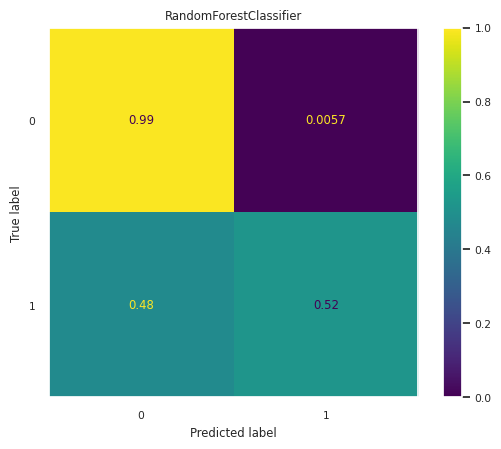

In [33]:
print_model_results(base_rf, base_rep_rf, cm)

In [34]:
max_rf_depth = max([estimator.get_depth() for estimator in base_rf.estimators_])
print(f"Deepest tree: {max_rf_depth}")

Deepest tree: 41


In [35]:
max_rf_estimators = base_rf.n_estimators
print(f"# of estimators: {max_rf_estimators}")

# of estimators: 100


### Grid Search

In [36]:
params = {'max_depth': [*range(4,10), None],                        
           "criterion": ["entropy", "gini"],                        
            "class_weight": [None, "balanced"],                     
           'n_estimators':list(range(10,max_rf_estimators+1,10))    
           }

results_rf = grid_search(params, ["recall_macro"], base_rf, Xtr, ytr, Xte, yte, n_jobs=9, overwrite_pickle=False, verbose=3)

Grid search already cached in cache/RandomForestClassifier__gridsearch.pickle - loading...


--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     26783
           1       0.14      0.84      0.24       339

    accuracy                           0.93     27122
   macro avg       0.57      0.89      0.60     27122
weighted avg       0.99      0.93      0.96     27122

Best parameters:
	bootstrap: True
	ccp_alpha: 0.0
	class_weight: balanced
	criterion: gini
	max_depth: 9
	max_features: sqrt
	max_leaf_nodes: None
	max_samples: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	n_estimators: 100
	n_jobs: None
	oob_score: False
	random_state: 69420
	verbose: 0
	warm_start: False

Feature importances:
	Type: 0.008
	Air temperature [K]: 0.120
	Process temperature [K]: 0.035
	Rotational speed [rpm]: 0.344
	Torque [Nm]: 0.326
	Tool wear [min]: 0.166


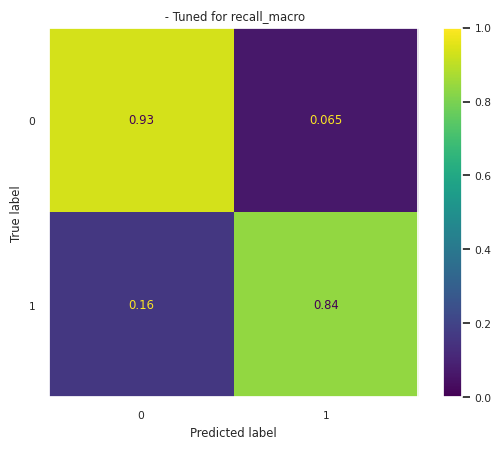

In [37]:
print_gridsearch_results(results_rf)

## AdaBoost

### Baseline

In [38]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
ada = AdaBoostClassifier(random_state=RANDOM_STATE)

ypred, base_rep_ada, cm = fit_and_predict(ada, Xtr, ytr, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.33      0.55      0.42       339

    accuracy                           0.98     27122
   macro avg       0.66      0.77      0.70     27122
weighted avg       0.99      0.98      0.98     27122

Best parameters:
	algorithm: SAMME.R
	base_estimator: deprecated
	estimator: None
	learning_rate: 1.0
	n_estimators: 50
	random_state: 69420

Feature importances:
	Type: 0.040
	Air temperature [K]: 0.120
	Process temperature [K]: 0.140
	Rotational speed [rpm]: 0.240
	Torque [Nm]: 0.240
	Tool wear [min]: 0.220


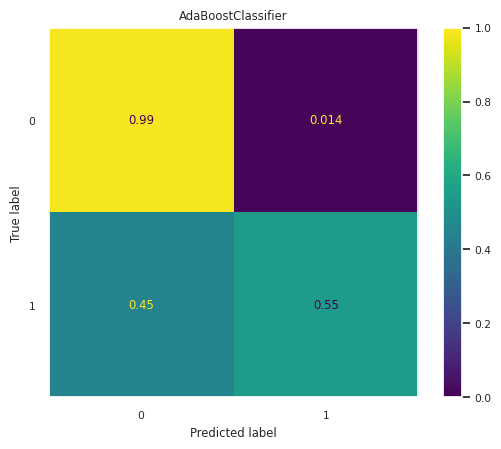

In [40]:
print_model_results(ada, base_rep_ada, cm)

### Grid search

In [41]:
results_ada = grid_search({'n_estimators':range(10, 100+1, 10),
                            'learning_rate':[0.2 * i for i in range(1, 8)],
                            }, ["recall_macro"], ada, Xtr, ytr, Xte, yte, overwrite_pickle=False, verbose=3, n_jobs=8)

Grid search already cached in cache/AdaBoostClassifier__gridsearch.pickle - loading...


--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26783
           1       0.34      0.55      0.42       339

    accuracy                           0.98     27122
   macro avg       0.67      0.77      0.70     27122
weighted avg       0.99      0.98      0.98     27122

Best parameters:
	algorithm: SAMME.R
	base_estimator: deprecated
	estimator: None
	learning_rate: 1.4000000000000001
	n_estimators: 100
	random_state: 69420

Feature importances:
	Type: 0.020
	Air temperature [K]: 0.210
	Process temperature [K]: 0.290
	Rotational speed [rpm]: 0.170
	Torque [Nm]: 0.210
	Tool wear [min]: 0.100


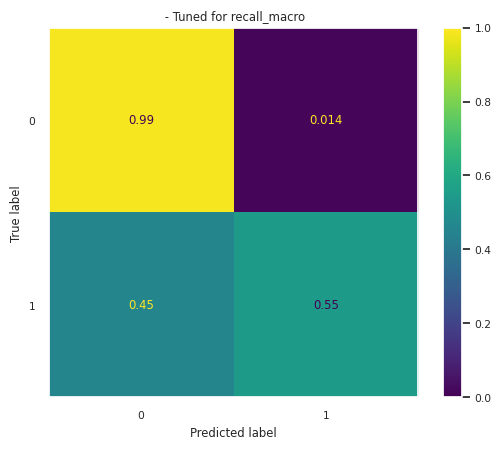

In [42]:
print_gridsearch_results(results_ada)

## K-Nearest Neighbor

### Baseline

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
kn = KNeighborsClassifier()

ypred, base_rep_knn, cm = fit_and_predict(kn, Xtr, ytr, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     26783
           1       0.28      0.59      0.38       339

    accuracy                           0.98     27122
   macro avg       0.64      0.78      0.68     27122
weighted avg       0.99      0.98      0.98     27122

Best parameters:
	algorithm: auto
	leaf_size: 30
	metric: minkowski
	metric_params: None
	n_jobs: None
	n_neighbors: 5
	p: 2
	weights: uniform



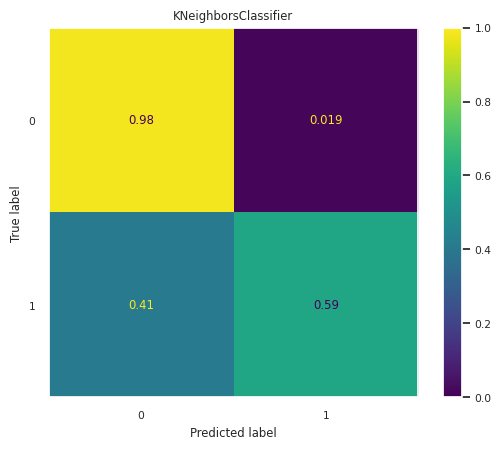

In [80]:
print_model_results(kn, base_rep_knn, cm)

### Grid search

In [89]:
base_params = {"n_neighbors": range(1, 30),
                "metric": ["euclidean", "manhattan"],
                "n_jobs": [2],
                }

btree_algo_params = {"algorithm": ["ball_tree", "kd_tree"],
                     "leaf_size": [10*i for i in range(1,10)],
                     **base_params}

other_algo_params = {"algorithm": ["auto", "brute"],
                     **base_params}

results_knn = grid_search([btree_algo_params, other_algo_params], ["recall_macro"],
                          kn, Xtr, ytr, Xte, yte, overwrite_pickle=False, n_jobs=6, verbose=3)

Grid search already cached in cache/KNeighborsClassifier__gridsearch.pickle - loading...


--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     26783
           1       0.27      0.45      0.34       339

    accuracy                           0.98     27122
   macro avg       0.63      0.72      0.66     27122
weighted avg       0.98      0.98      0.98     27122

Best parameters:
	algorithm: kd_tree
	leaf_size: 40
	metric: manhattan
	metric_params: None
	n_jobs: 2
	n_neighbors: 1
	p: 2
	weights: uniform



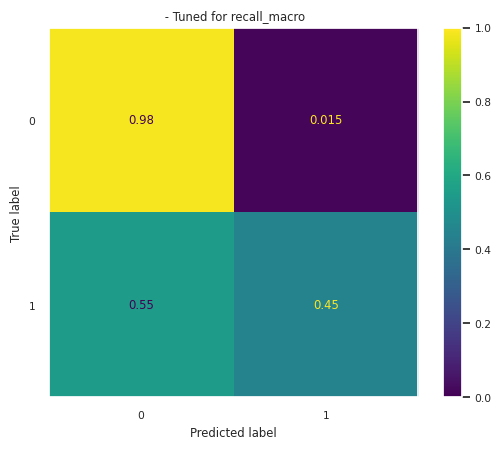

In [88]:
print_gridsearch_results(results_knn)

## Gaussian Naive Bayes

### Baseline

In [48]:
from sklearn.naive_bayes import GaussianNB

In [49]:
gnb = GaussianNB()

ypred, base_rep_gnb, cm = fit_and_predict(gnb, Xtr, ytr, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     26783
           1       0.18      0.33      0.23       339

    accuracy                           0.97     27122
   macro avg       0.58      0.66      0.61     27122
weighted avg       0.98      0.97      0.98     27122

Best parameters:
	priors: None
	var_smoothing: 1e-09



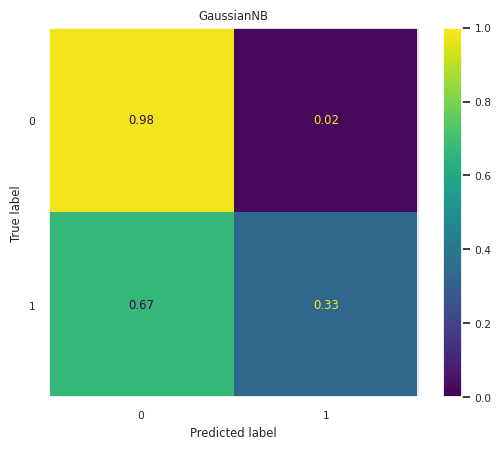

In [50]:
print_model_results(gnb, base_rep_gnb, cm)

### Grid search

In [51]:
results_gnb = grid_search({'var_smoothing': [10**(-exp) for exp in range(1, 60)]},
                            ["recall_macro"], gnb, Xtr, ytr, Xte, yte)

Grid search already cached in cache/GaussianNB__gridsearch.pickle - loading...


--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     26841
           1       0.17      0.34      0.23       382

    accuracy                           0.97     27223
   macro avg       0.58      0.66      0.61     27223
weighted avg       0.98      0.97      0.97     27223

Best parameters:
	priors: None
	var_smoothing: 1e-08



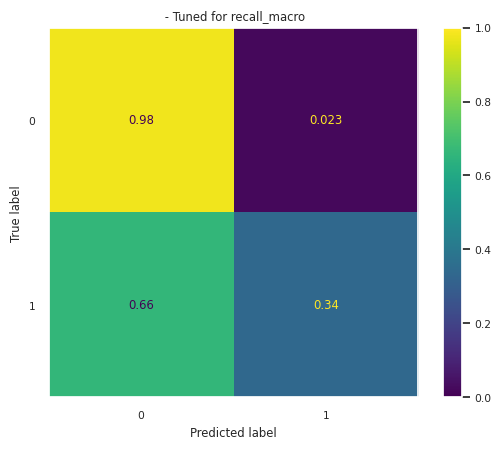

In [52]:
print_gridsearch_results(results_gnb)

## Perceptron

### Baseline

In [53]:
from sklearn.linear_model import Perceptron

In [54]:
lp = Perceptron(random_state=RANDOM_STATE)

ypred, base_rep_lp, cm = fit_and_predict(lp, Xtr, ytr, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     26783
           1       0.10      0.63      0.18       339

    accuracy                           0.93     27122
   macro avg       0.55      0.78      0.57     27122
weighted avg       0.98      0.93      0.95     27122

Best parameters:
	alpha: 0.0001
	class_weight: None
	early_stopping: False
	eta0: 1.0
	fit_intercept: True
	l1_ratio: 0.15
	max_iter: 1000
	n_iter_no_change: 5
	n_jobs: None
	penalty: None
	random_state: 69420
	shuffle: True
	tol: 0.001
	validation_fraction: 0.1
	verbose: 0
	warm_start: False



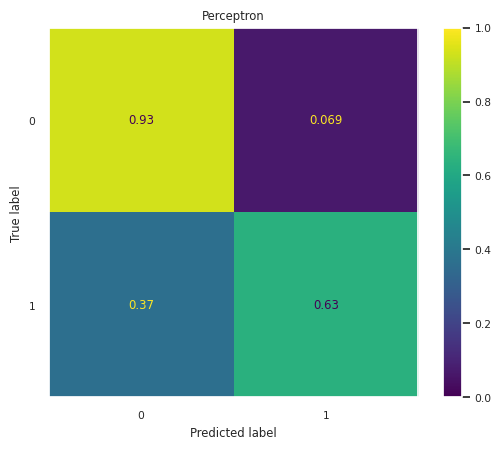

In [55]:
print_model_results(lp, base_rep_lp, cm)

### Grid search

In [56]:
base_params = {'early_stopping': [True,False],
                'class_weight':[None,'balanced'],
                "eta0": [10.0**i for i in range(-5, 2)],
                }

elasticnet_params = {'l1_ratio': [0.1, 0.15, 0.5, 0.9],
                    'penalty': ["elasticnet"],
                    **base_params
                    }

other_penalties_params = {'penalty': ["l1", "l2", None],
                          **base_params
                        }

results_perc = grid_search([elasticnet_params, other_penalties_params], ["recall_macro"], lp, Xtr, ytr, Xte, yte)

Grid search already cached in cache/Perceptron__gridsearch.pickle - loading...


--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     26783
           1       0.06      0.72      0.11       339

    accuracy                           0.85     27122
   macro avg       0.53      0.79      0.51     27122
weighted avg       0.98      0.85      0.91     27122

Best parameters:
	alpha: 0.0001
	class_weight: balanced
	early_stopping: True
	eta0: 1.0
	fit_intercept: True
	l1_ratio: 0.15
	max_iter: 1000
	n_iter_no_change: 5
	n_jobs: None
	penalty: None
	random_state: 69420
	shuffle: True
	tol: 0.001
	validation_fraction: 0.1
	verbose: 0
	warm_start: False



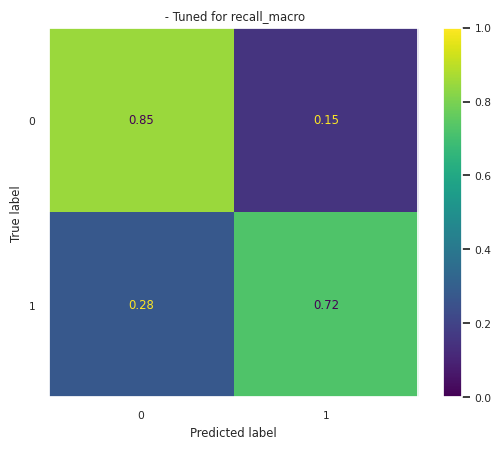

In [57]:
print_gridsearch_results(results_perc)

## Support Vector Machine

### Baseline

In [58]:
from sklearn.svm import SVC

In [59]:
svc = SVC(random_state=RANDOM_STATE)
overwrite = False
pickle_path = f"{CACHE_DIR}/SVC__baseline.pickle"
cached = os.path.isfile(pickle_path)

if cached and not overwrite:
    print(f"Baseline model already cached in {pickle_path} - loading...")
    tmp = load_pickle(pickle_path)
else:
    if cached and overwrite:
        print(f"Overwriting cached model...")

    tmp = [svc, fit_and_predict(svc, Xtr, ytr, Xte, yte)]
    dump_pickle(tmp, pickle_path)

svc = tmp[0]
y_pred, base_rep_svc, cm = tmp[1]

Baseline model already cached in cache/SVC__baseline.pickle - loading...


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26783
           1       0.41      0.66      0.51       339

    accuracy                           0.98     27122
   macro avg       0.70      0.82      0.75     27122
weighted avg       0.99      0.98      0.99     27122

Best parameters:
	C: 1.0
	break_ties: False
	cache_size: 200
	class_weight: None
	coef0: 0.0
	decision_function_shape: ovr
	degree: 3
	gamma: scale
	kernel: rbf
	max_iter: -1
	probability: False
	random_state: 69420
	shrinking: True
	tol: 0.001
	verbose: False



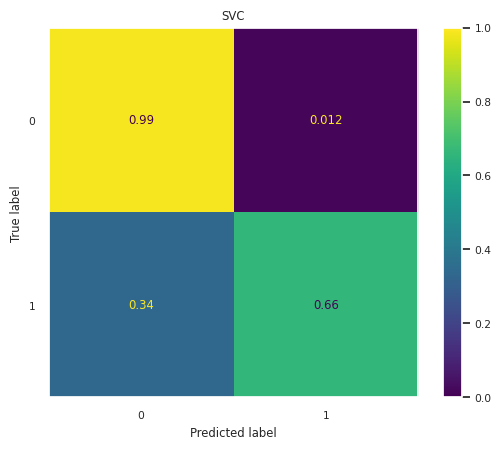

In [60]:
print_model_results(svc, base_rep_svc, cm)

### Grid search

Due to the extremely long training time of this model, the tuning has been performed separately for the two kernels tested (`rbf` and `poly`).

Grid search already cached in cache/SVC__gridsearch_rbf.pickle - loading...
--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     26783
           1       0.12      0.81      0.21       339

    accuracy                           0.92     27122
   macro avg       0.56      0.87      0.59     27122
weighted avg       0.99      0.92      0.95     27122

Best parameters:
	C: 100
	break_ties: False
	cache_size: 200
	class_weight: balanced
	coef0: 0.0
	decision_function_shape: ovr
	degree: 3
	gamma: auto
	kernel: rbf
	max_iter: -1
	probability: False
	random_state: 69420
	shrinking: False
	tol: 0.001
	verbose: False



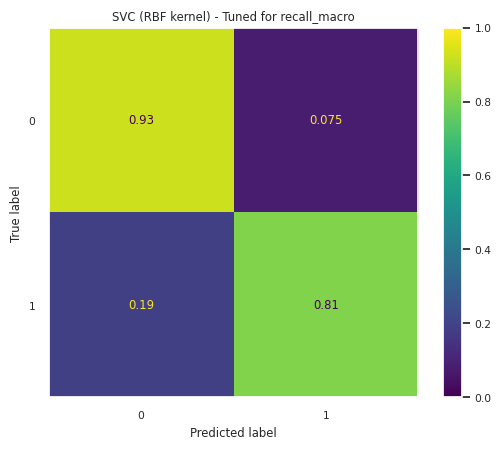

In [61]:
# WARNING: using Colab, this took more than 1 hr
results_svc_rbf = grid_search({'kernel': ['rbf'],
                    'gamma': ["scale","auto",1e-3, 1e-4],
                    'C': [1, 10, 100],
                    "shrinking": [True, False],
                    'class_weight': [None, "balanced"]},
                    ["recall_macro"], svc, Xtr, ytr, Xte, yte,
                    n_splits=2, n_jobs=10, overwrite_pickle=False, verbose=3,
                    pickle_file="SVC__gridsearch_rbf.pickle")

print_gridsearch_results(results_svc_rbf, cm_model_name="SVC (RBF kernel)")

Grid search already cached in cache/SVC__gridsearch_poly.pickle - loading...
--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     26783
           1       0.10      0.85      0.18       339

    accuracy                           0.90     27122
   macro avg       0.55      0.88      0.57     27122
weighted avg       0.99      0.90      0.94     27122

Best parameters:
	C: 1.0
	break_ties: False
	cache_size: 200
	class_weight: balanced
	coef0: 0.0
	decision_function_shape: ovr
	degree: 3
	gamma: scale
	kernel: poly
	max_iter: -1
	probability: False
	random_state: 69420
	shrinking: True
	tol: 0.001
	verbose: False



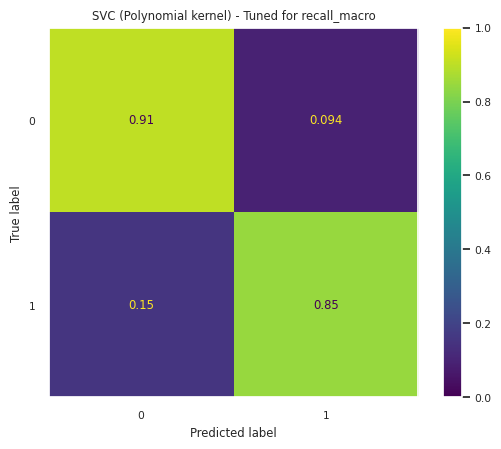

In [62]:
# WARNING: using Colab, this took more than 1 hr
results_svc_poly = grid_search({'kernel': ['poly'],
                    'gamma': ["scale","auto",1e-3, 1e-4],
                    'C': [1, 10, 100],
                    'class_weight': [None, "balanced"]},
                    ["recall_macro"], svc, Xtr, ytr, Xte, yte,
                    n_splits=2, n_jobs=10, overwrite_pickle=False, verbose=3,
                    pickle_file="SVC__gridsearch_poly.pickle")

print_gridsearch_results(results_svc_poly, cm_model_name="SVC (Polynomial kernel)")

In [63]:
# We see that, although just slightly, the best model uses the poly kernel
results_svc = results_svc_poly

## Gradient descent

### Baseline

In [64]:
from sklearn.linear_model import SGDClassifier

In [65]:
sgd = SGDClassifier(random_state=RANDOM_STATE)

y_pred, base_rep_sgd, cm = fit_and_predict(sgd, Xtr, ytr, Xte, yte)

Fitting model...done
Testing...done


Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26783
           1       0.52      0.14      0.21       339

    accuracy                           0.99     27122
   macro avg       0.75      0.57      0.60     27122
weighted avg       0.98      0.99      0.98     27122

Best parameters:
	alpha: 0.0001
	average: False
	class_weight: None
	early_stopping: False
	epsilon: 0.1
	eta0: 0.0
	fit_intercept: True
	l1_ratio: 0.15
	learning_rate: optimal
	loss: hinge
	max_iter: 1000
	n_iter_no_change: 5
	n_jobs: None
	penalty: l2
	power_t: 0.5
	random_state: 69420
	shuffle: True
	tol: 0.001
	validation_fraction: 0.1
	verbose: 0
	warm_start: False



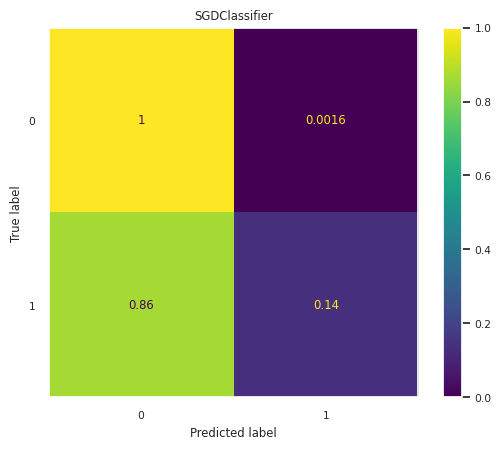

In [66]:
print_model_results(sgd, base_rep_sgd, cm)

### Grid search

In [67]:
base_params = {'class_weight': [None, "balanced"],
               "alpha": [10**e for e in range(-5, 2)],
               "penalty": ["l2", "l1", "elasticnet", None],
               "loss": ["hinge", "log_loss", "modified_huber", "perceptron"],
               }

# The eta0 parameter is disregarded when learning_rate="optimal"
optimal_lr_params = {"learning_rate": ["optimal"], 
                     **base_params}

other_lr_params = {"learning_rate": ["constant", "invscaling", "adaptive"],
                     "eta0": [0.01, 0.1, 1],
                     **base_params}

results_sgd = grid_search([optimal_lr_params, other_lr_params], ["recall_macro"], sgd, Xtr, ytr, Xte, yte, overwrite_pickle=False, verbose=3, n_jobs=8)

Grid search already cached in cache/SGDClassifier__gridsearch.pickle - loading...


--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     26783
           1       0.05      0.80      0.09       339

    accuracy                           0.79     27122
   macro avg       0.52      0.80      0.48     27122
weighted avg       0.98      0.79      0.87     27122

Best parameters:
	alpha: 1
	average: False
	class_weight: balanced
	early_stopping: False
	epsilon: 0.1
	eta0: 0.1
	fit_intercept: True
	l1_ratio: 0.15
	learning_rate: invscaling
	loss: hinge
	max_iter: 1000
	n_iter_no_change: 5
	n_jobs: None
	penalty: elasticnet
	power_t: 0.5
	random_state: 69420
	shuffle: True
	tol: 0.001
	validation_fraction: 0.1
	verbose: 0
	warm_start: False



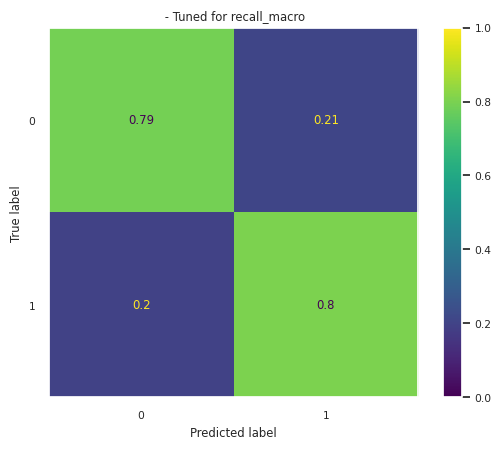

In [68]:
print_gridsearch_results(results_sgd)

The value for the `loss` parameter was selected to be `"hinge"`. As stated in the documentation, this means that the model is actually fitting a *linear* support vector classifier. Indeed, using the `LinearSVC` class, which directly implements the same thing, we see basically the same results, both before and after tuning:

Fitting model...done
Testing...done
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26783
           1       0.32      0.17      0.22       339

    accuracy                           0.99     27122
   macro avg       0.66      0.58      0.61     27122
weighted avg       0.98      0.99      0.98     27122

Best parameters:
	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	loss: squared_hinge
	max_iter: 6000
	multi_class: ovr
	penalty: l2
	random_state: 69420
	tol: 0.0001
	verbose: 0

Grid search already cached in cache/SVC__linear.pickle - loading...
--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     26783
           1       0.05      0.78      0.09       339

    accuracy                           0.81     27122
   macro avg       0.52      0.79      0.49     

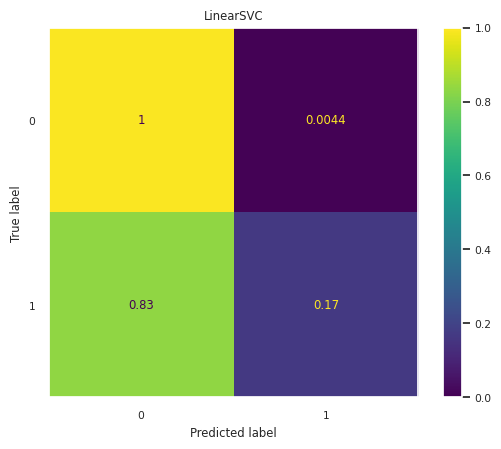

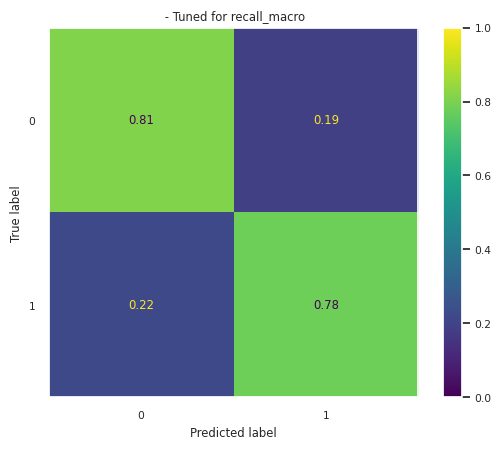

In [69]:
from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=RANDOM_STATE, max_iter=6000, dual=False)

ypred, base_rep_lsvm, cm = fit_and_predict(lsvm, Xtr, ytr, Xte, yte)

print_model_results(lsvm, base_rep_lsvm, cm)

results_svc_linear = grid_search({'penalty': ["l1", "l2"],
                    'C': [1, 10, 100],
                    'class_weight': [None, "balanced"]},
                    ["recall_macro"], lsvm, Xtr, ytr, Xte, yte,
                    n_jobs=10, overwrite_pickle=False, verbose=3, pickle_file="SVC__linear.pickle")

print_gridsearch_results(results_svc_linear)

# Conclusions

In [70]:
reports = {
    "DecisionTree": [base_rep_dt, results_dt],
    "RandomForest": [base_rep_rf, results_rf],
    "AdaBoost": [base_rep_ada, results_ada],
    "KNN": [base_rep_knn, results_knn],
    "GaussianNB": [base_rep_gnb, results_gnb],
    "Perceptron": [base_rep_lp, results_perc],
    "SVC": [base_rep_svc, results_svc],
    "SGD": [base_rep_sgd, results_sgd]
}

reports = {k : (report_str_to_dict(v0), report_str_to_dict(v1["recall_macro"]["report"])) for k, v in reports.items() for v0, v1 in [v]}

In [71]:
model_names = reports.keys()
reports_baseline = {k: v[0] for k, v in reports.items()}
reports_gscv = {k: v[1] for k, v in reports.items()}

In [72]:
recalls_gscv = {model: rep["macro_avg"]["recall"] for model, rep in reports_gscv.items()}
recalls_baseline = {model: rep["macro_avg"]["recall"] for model, rep in reports_baseline.items()}

Firstly, this plot shows an overall comparison of each model's performance for each class before and after tuning, measured through the recall for each class. As already stated, this remains basically the only reliable metric to evalutate these models due to the extreme imbalance found in the dataset.

*After tuning*, the models are thus classified as follows:

|                   | _Class 1 recall_ | _Recall (macro) average_ |
|:-----------------:|:----------------:|:------------------------:|
| **Random Forest** |        84%       |          **89%**         |
| **SVM**           |      **85%**     |            88%           |
| SGD               |        80%       |            80%           |
| Perceptron        |        72%       |            79%           |
| Decision Tree     |        71%       |            83%           |
| AdaBoost          |        55%       |            77%           |
| KNN               |        45%       |            72%           |
| Gaussian NB       |        34%       |            66%           |


The tuned parameters of the two "winning" models are:
- Random Forest
    - `max_depth`: 9
    - `criterion`: `"gini"`
    - `class_weight`: `"balanced"`
    - `n_estimators`: 100
- Support Vector Machine
    - `kernel`: `"poly"`
    - `class_weight`: `"balanced"`
    - `shrinking`: `False`
    - `gamma`: `"auto"`
    - `C`: 100
However, being a few orders of magnitude faster to train, the former may be considered more optimal.

The particularly bad performance of the KNN and Gaussian Naive Bayes classifiers was, to be fair, to be expected, though for different reasons:
- For the KNN model, the pairplots at the beginning show that the two classes are mostly overlapping and to not form well distinct clusters
- For the GNB model, its basic assumption of conditional independence between the attributes is clearly faulty in this context, since (for example) the rotational speed of a machine obviously influences its operating temperature

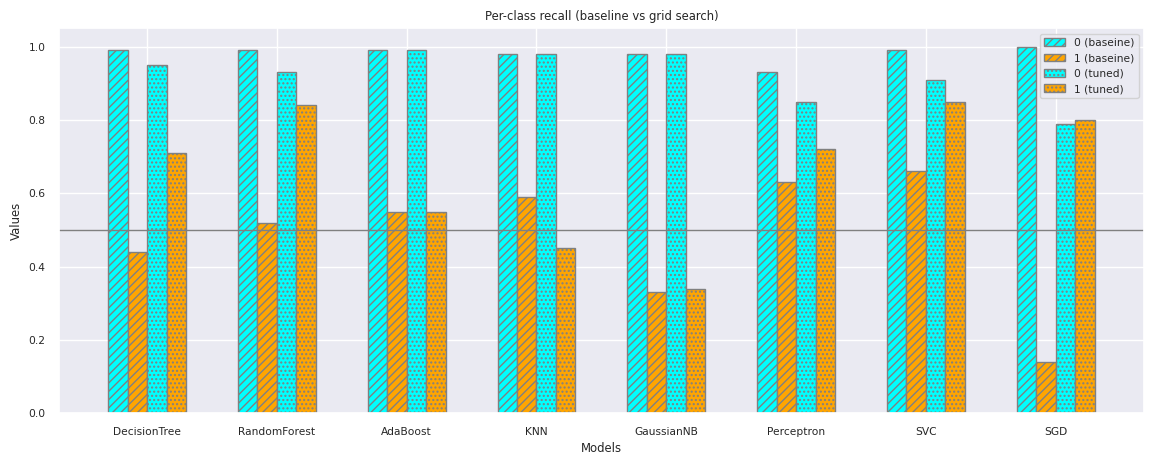

In [73]:
# Bar plot properties
bar_width = 0.15  # Width of the bars

# Number of objects
n_objects = len(model_names)

# Create a figure and axis
_, ax = plt.subplots(figsize=(14, 5))

# Y positions for groups of bars
index = np.arange(n_objects)

tmp = [
    [reports_baseline[m]["0"]["recall"] for m in model_names],
    [reports_baseline[m]["1"]["recall"] for m in model_names],
    [reports_gscv[m]["0"]["recall"] for m in model_names],
    [reports_gscv[m]["1"]["recall"] for m in model_names],
]

for i, t in enumerate(tmp):
    ax.bar(index + bar_width*(i - 1.5), t, bar_width, edgecolor='grey',
           color="cyan" if (i%2) == 0 else "orange",
           label=f"{i%2} ({'baseine' if i < 2 else 'tuned'})",
           hatch="////" if i < 2 else "....")

ax.legend()

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Values')
ax.set_xticks(index)
ax.set_xticklabels(model_names)
ax.set_title('Per-class recall (baseline vs grid search)')

# Horizontal line at y=.5
ax.axhline(.5, color='grey', lw=1)

# Show the plot
plt.show()

The following plots shows the *changes* in the recall metric, both for the macro average (left) and just for class 1 (right). It is noteworthy how the SGD model went from a baseline of 57% up to 80%, by far the largest improvement.

The worst performing models either didn't improve (AdaBoost and Gaussian Naive Bayes) or became worse (K-Nearest Neighbor). This may have two reasons:
- none of these have a "class weight" parameter, unlike the other five, and thus couldn't be tuned to "pay more attention" to one class than the other
- cross-validation is performed on a *slice* of the training set (unlike the default model, which used all of it). This is especially damning for the KNN classifier because it doesn't really perform any analysis of the training data, instead simply using it "as-is".

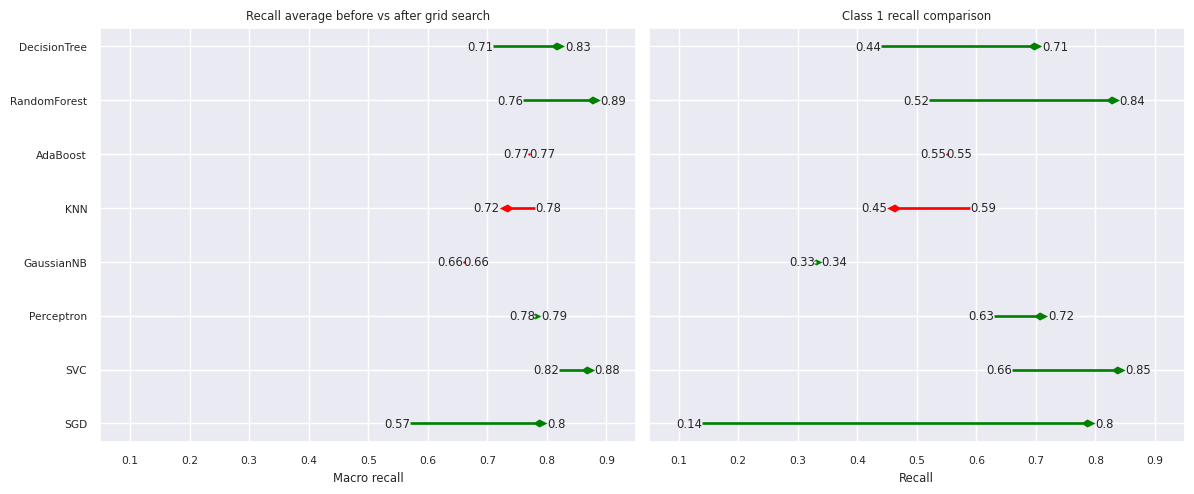

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_old_to_new(recalls_baseline, recalls_gscv,
                xlabel="Macro recall", ylabel="", x_range=(.1, .9), ax=ax1,
                title="Recall average before vs after grid search")

class1_recalls_gscv = {model: rep["1"]["recall"] for model, rep in reports_gscv.items()}
class1_recalls_baseline = {model: rep["1"]["recall"] for model, rep in reports_baseline.items()}

plot_old_to_new(class1_recalls_baseline, class1_recalls_gscv, ax=ax2, yticks=False,
                xlabel="Recall", ylabel="", x_range=(.1, .9), title="Class 1 recall comparison")

fig.tight_layout()
plt.show()

The main focus of this project ended up being *how to deal with severly imbalanced data*, more than the classification task itself. This, at least for the given dataset, was achieved in three main ways:
1. using a per-class weighing of the datapoints, when supported
2. performing dataset resampling during preprocessing to make the minority class easier to learn
3. targeting the `recall_macro` scoring metric when tuning instead of accuracy or precision
    - this metric is an *unweighted* average of the recalls for each class, making thus sure that the result doesn't de facto only account for the majority datapoints
    - the majority class being so dominant, it is acceptable to be slightly less accurate in classifying it if it means being way more sensitive to the minority